In [16]:

import numpy as np

import gymnasium as gym  # Correct way to import Gymnasium
from gymnasium.spaces import Dict, Discrete, Box
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.constants import DIR_TO_VEC
from minigrid.core.grid import Grid
from minigrid.core.actions import Actions
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from gymnasium.utils.play import play
from gymnasium import ObservationWrapper, spaces
from minigrid.wrappers import FullyObsWrapper
import pandas as pd
# Visualization imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.special import logsumexp


import os, glob
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys


from moviepy import VideoFileClip, TextClip, CompositeVideoClip
from moviepy import ImageSequenceClip

import random
SEED = 42
np.random.seed(SEED)

to run this code, you will need an environment that supports all the above imports, the more_data_2025 directory with new trajectory csvs, floor_overlay_labels, and walkalble_positions_with_visibility, and the stored_vars.pkl file with preprocessed trajectories (museum_df2_cleaned), statemap, and museum_mask 

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

In [3]:
with open("stored_vars.pkl", "rb") as f:
    stored = pickle.load(f)

# Unpack by name
museum_mask_03m = stored["museum mask"]
# museum_df       = stored["museum_df"]
state_map       = stored["state map"]
museum_df2_cleaned = stored["museum_df_cleaned2"] # cleaned and downsampled version of new museum data



In [4]:
%matplotlib inline

In [5]:
mask = museum_mask_03m
mask = np.flipud(mask)

traces from museum

In [6]:
museum_df2_cleaned

,file,time,x,y,state,visibility
0,20220825_track_00004_AB.csv,"[0.0, 0.00022768670309653916, 0.00091074681238...","[0.028985507246376812, 0.028985507246376812, 0...","[0.7297297297297297, 0.7297297297297297, 0.756...","[0.09911242603550297, 0.09911242603550297, 0.0...","[8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
1,20220825_track_00006_BA.csv,"[0.06593820648078372, 0.06669178598342125, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,20220825_track_00010_AB.csv,"[0.005380476556495004, 0.006661542403279528, 0...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6756756756756757, 0.6756756756756757, 0.675...","[0.17825443786982248, 0.17825443786982248, 0.1...","[8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 8, 8, 8, 8, 8, ..."
3,20220825_track_00017_BA.csv,"[0.04217045119433795, 0.04335004423473902, 0.0...","[0.7971014492753623, 0.8115942028985508, 0.811...","[0.16216216216216217, 0.13513513513513514, 0.1...","[0.9607988165680473, 0.9940828402366864, 0.994...","[10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9,..."
4,20220825_track_00031_BA.csv,"[0.08922742110990206, 0.09031556039173014, 0.0...","[0.7971014492753623, 0.7971014492753623, 0.797...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9933431952662722, 0.9933431952662722, 0.993...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
...,...,...,...,...,...,...
95,20220825_track_02117_AB.csv,"[0.0, 0.00044742729306487697, 0.00089485458612...","[0.07246376811594203, 0.07246376811594203, 0.0...","[0.7837837837837838, 0.7837837837837838, 0.783...","[0.03106508875739645, 0.03106508875739645, 0.0...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
96,20220826_track_00008_BB.csv,"[0.04019779869197639, 0.04290955495294305, 0.0...","[0.8115942028985508, 0.8115942028985508, 0.811...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.9940828402366864, 0.9940828402366864, 0.994...","[9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
97,20220826_track_00013_BA.csv,"[0.29768941429339063, 0.2982267598065556, 0.29...","[0.782608695652174, 0.782608695652174, 0.78260...","[0.13513513513513514, 0.13513513513513514, 0.1...","[0.992603550295858, 0.992603550295858, 0.99260...","[8, 8, 8, 10, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
98,20220826_track_00030_AB.csv,"[0.0024760647078243643, 0.0027236711786068008,...","[0.014492753623188406, 0.014492753623188406, 0...","[0.6486486486486487, 0.6486486486486487, 0.648...","[0.21819526627218935, 0.21819526627218935, 0.2...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, ..."


# plot all traces

In [13]:
#grabs more_data_2025 folder which has all new museum traces and a floor_overlay_labels.csv file

In [14]:
def floorplan_trajectories_ir(
    rect_csv='floor_overlay_labels.csv',
    cluster_pattern='cluster_*.csv',
    cluster_dir='.',
    plot_separate=True,
    filter_files=None          # list of filenames (e.g. ['cluster_005.csv'])
):
    """
    Draw the floor plan and overlay selected trajectory CSVs.

    Parameters
    ----------
    rect_csv : str
        CSV containing rectangle definitions (x, y, width, height, name).
    cluster_pattern : str
        Glob pattern for trajectory CSVs (default 'cluster_*.csv').
    cluster_dir : str
        Directory where CSVs live.
    plot_separate : bool
        If True, make a subplot grid of individual traces.
    filter_files : list[str] | None
        If provided, only plot these filenames (basename match).
    """
    pix_to_m = 0.003175

    # ── read floor rectangles ────────────────────────────────────────────
    rect_path = os.path.join(cluster_dir, rect_csv)
    T = pd.read_csv(rect_path)

    # ── gather trajectory files ─────────────────────────────────────────-
    all_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))
    if filter_files:
        wanted = {os.path.basename(f) for f in filter_files}
        csv_files = [f for f in all_files if os.path.basename(f) in wanted]
    else:
        csv_files = all_files

    n_files = len(csv_files)
    colors = cm.get_cmap('tab20', n_files)

    # ── figure 1: floor plan + selected traces ───────────────────────────
    fig1, ax1 = plt.subplots(figsize=(8, 6))

    # draw rectangles
    for _, row in T.iterrows():
        x, y = row['x'] * pix_to_m, row['y'] * pix_to_m
        w, h = row['width'] * pix_to_m, row['height'] * pix_to_m
        ax1.add_patch(plt.Rectangle((x, y), w, h,
                                    edgecolor='gray', facecolor='none', lw=1))
        ax1.text(x, y + h + 0.05, row['name'],
                 fontsize=8, color='black', va='bottom', ha='left')

    # draw trajectories
    for i, f in enumerate(csv_files):
        data = pd.read_csv(f)
        x = data.iloc[:, 1] * pix_to_m
        y = data.iloc[:, 2] * pix_to_m
        ax1.plot(x, y, '.', color=colors(i), lw=0.5, ms=1,
                 label=os.path.basename(f))

    ax1.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
    ax1.set_ylim(0, 3500 * pix_to_m)
    ax1.set_aspect('equal')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Floor Plan and Selected Trajectories')
    # ax1.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()
    plt.show()

    if plot_separate and n_files:
            cols = 4
            rows = int(np.ceil(n_files / cols))
            fig2, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
            axes = axes.flatten()

            for i, f in enumerate(csv_files):
                data = pd.read_csv(f)
                x = data.iloc[:, 1] * pix_to_m
                y = data.iloc[:, 2] * pix_to_m
                ax = axes[i]

                # draw floor rectangles on each subplot
                for _, row in T.iterrows():
                    rect_x = row['x'] * pix_to_m
                    rect_y = row['y'] * pix_to_m
                    rect_w = row['width'] * pix_to_m
                    rect_h = row['height'] * pix_to_m
                    ax.add_patch(plt.Rectangle(
                        (rect_x, rect_y), rect_w, rect_h,
                        edgecolor='gray', facecolor='none', lw=0.5))
                    ax.text(rect_x, rect_y + rect_h + 0.02, row['name'],
                            fontsize=5, color='black', va='bottom', ha='left')

                ax.plot(x, y, '.', color=colors(i), lw=0.5, ms=1)
                ax.set_xlim(-1000 * pix_to_m, 7000 * pix_to_m)
                ax.set_ylim(0, 3500 * pix_to_m)
                ax.set_aspect('equal')
                ax.set_title(f"cluster {os.path.basename(f)[8:11]}", fontsize=7)

            # remove empty panels
            for j in range(i + 1, len(axes)):
                fig2.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_36342/3080272680.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_files)


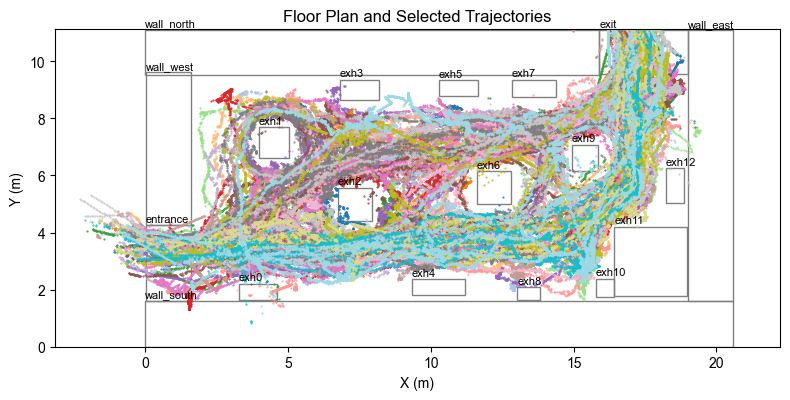

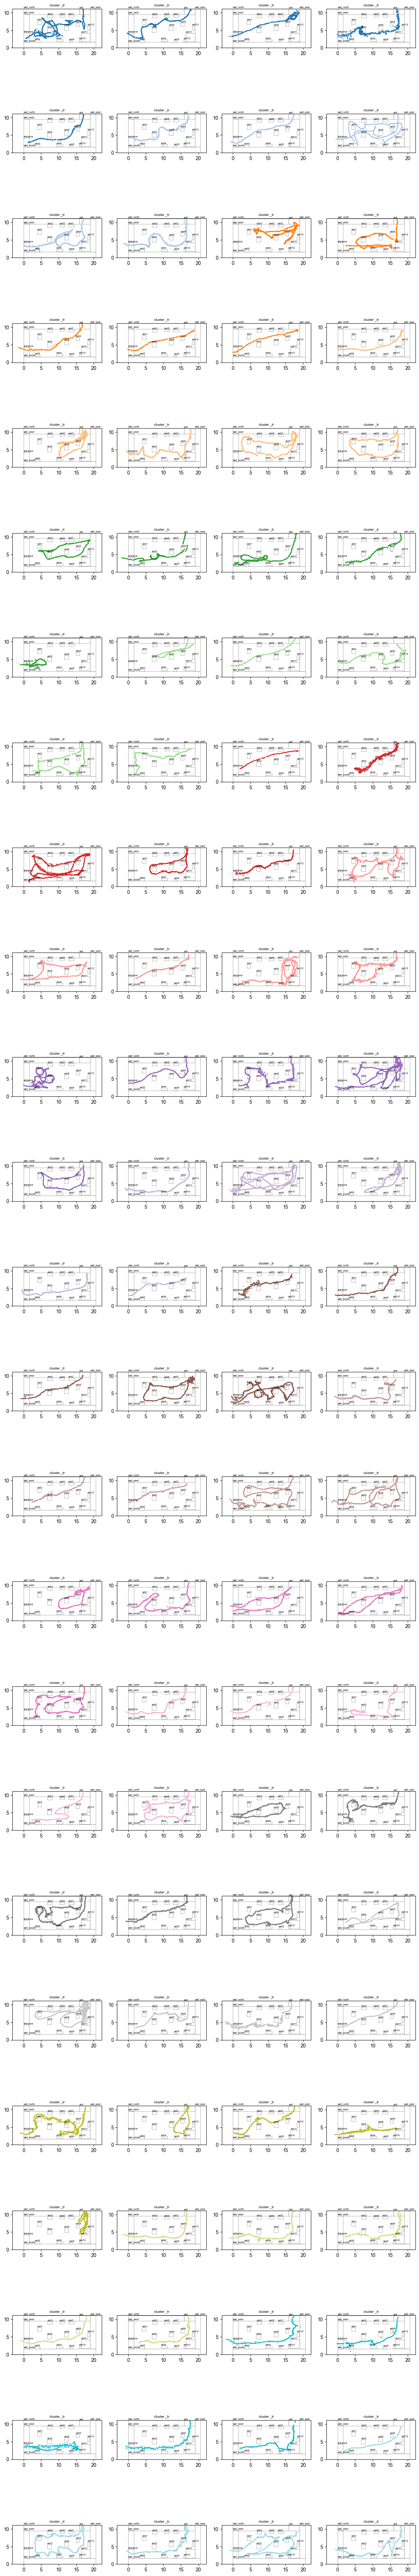

In [17]:
floorplan_trajectories_ir(cluster_pattern='*_track_*.csv', cluster_dir='more_data_2025')

# Define Environment

In [18]:

class SimpleEnv(MiniGridEnv):
    def __init__(
            self, 
            agent_start_pos=(1, 30), # bottom left entrance ( 1, 30) top right corner (63, 5)
            agent_start_dir=0, 
            max_steps=50,
            mask = None, 
            reward_mask = None,
            
            **kwargs,
    ):
        
    
        height, width = mask.shape
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.agent_dir = 0 #facing up always
        # self.goal_pos = (30, 15)
        self.mask = mask
        self.reward_mask = reward_mask
        self.visited_reward_0 = set()  # holds (x, y) tuples

        
        
        
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            # grid_size=max(width, height),
            width=width,
            height=height,
            max_steps=max_steps,
            **kwargs,
        )

        # Restore correct values
        self.width = width
        self.height = height

        self.action_space = gym.spaces.Discrete(5)
    @staticmethod
    def _gen_mission():
        return "Museum"

    def _gen_grid(self, width, height):

        self.grid = Grid(self.width, self.height)

        for y in range(self.mask.shape[0]):
            for x in range(self.mask.shape[1]):
                if not self.mask[y, x]:
                    self.grid.set(x, y, Wall())



        #place goal
        # self.put_obj(Goal(), 30, 15)

        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos #check this
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "Museum"

        # print(f"agent_start = {self.agent_start_pos}")
        print(f"[DEBUG] Initialized grid {self.width}x{self.height}, agent at {self.agent_pos}")

    def step(self, action):
        terminated = False
        truncated = False
        x, y = map(int, self.agent_pos)
   

        # Define absolute movement
        if action == 0:      # stay
            dx, dy = 0, 0
        elif action == 1:    # up
            dx, dy = 0, -1
        elif action == 2:    # down
            dx, dy = 0, 1
        elif action == 3:    # left
            dx, dy = -1, 0
        elif action == 4:    # right
            dx, dy = 1, 0
        else:
            raise ValueError(f"Invalid action: {action}")

        new_x, new_y = int(x + dx), int(y + dy)

        # Stay in bounds
        if not (0 <= new_x < self.width and 0 <= new_y < self.height):
            new_x, new_y = x, y

        # Check for wall
        target_cell = self.grid.get(new_x, new_y)
        if target_cell is not None and not target_cell.can_overlap():
            new_x, new_y = x, y  # can't move into wall

        self.agent_pos = (new_x, new_y)


        reward = 0 # hard coded because reward logic doesn't matter
        obs = self.gen_obs()

        info = {}

        return obs, reward, terminated, truncated, info
    
    
    def count_states(self):
        free_cells = sum(1 for x in range(self.grid.width)
                      for y in range(self.grid.height)
                      if not self.grid.get(x, y)) * 4
        return free_cells 


In [19]:
env = SimpleEnv(render_mode= None, mask = mask, reward_mask= None)
env.reset();

[DEBUG] Initialized grid 69x37, agent at (1, 30)


# Functions for MaxEnt IRL

In [20]:
def make_demos(museum_df):

    """Collection of features from museum trajectories"""
    df = museum_df
     # a list of features for each traces
    demos = []
    for trace in np.arange(df.shape[0]):
        demo = []
        for i in range(len(df.iloc[trace, 1])):
            t, x, y, state, visibility = df.iloc[trace, 1][i], df.iloc[trace, 2][i], df.iloc[trace, 3][i], df.iloc[trace, 4][i], df.iloc[trace, 5][i]
            feat = np.array([t, x, y, state, visibility])
            demo.append(feat)
        demos.append(np.array(demo))
    return demos

  
    

In [21]:
# select what museum_df to use
museum_df = museum_df2_cleaned

In [22]:
demos = make_demos(museum_df)

In [30]:
#visibility needs to come from 'walkable_positions_with_visibility.csv'
visibility_df = pd.read_csv('more_data_2025/walkable_positions_with_visibility.csv')
c = visibility_df.iloc[:, 3].values 

In [25]:

### functions for my actual code ###

def state_to_feature(state, t, state_map, c, T):
    """
    Return feature vector [t, x, y, state, visibility] for one state.
    """
    # Find (x, y) for this state in the flipped+transposed map
    x = np.where(np.flipud(state_map).T == state)[0][0]
    y = np.where(np.flipud(state_map).T == state)[1][0]

    visibility = c[state]

    W,H = state_map.T.shape
    nstates = state_map.max() + 1

    return np.array([t/ T, x/W, y/H, state/nstates, visibility], dtype=float)



def collect_expert_features(demos):
    """Compute average feature expectations from expert trajectories."""
    feats = []
    for traj in demos:  # each traj = list of (state, action, next_state)
        fsum = np.zeros(demos[0][0].shape[0])  # fix later
        for (t, x, y, state, visibility) in traj:
            fsum += np.array([t, x, y, state, visibility])
        feats.append(fsum)
    return np.mean(feats, axis=0)



# -------------------
# Ue distribution ( expert feature counts)
# --------------------
def demo_state_counts(demos, env):
    n_states = env.width * env.height
    counts = np.zeros(n_states)
    for demo in demos:
        for _, _, _, state, _ in demo:
            counts[int(state)] += 1
    return counts / np.sum(counts)

#------------------
# Calculate P for env
# ____________________

def build_transition_model(env, state_map):
    """
    Build a tabular transition model P for a gridworld with given actions.

    Parameters
    ----------
    width, height : int
        Grid dimensions.
    state_map : np.ndarray (height, width)
        Mapping from (y, x) -> state index, -1 if not walkable.
    action_deltas : dict
        Mapping action -> (dx, dy).

    Returns
    -------
    P : dict
        P[state][action] = [(prob, next_state, reward, done)]
    """

    # 9-action scheme (with diagonals)
    action_deltas = {
        0: (0, 0),    # stay
        1: (0, -1),   # up
        2: (0, 1),    # down
        3: (-1, 0),   # left
        4: (1, 0),    # right
        # 5: (-1, -1),  # up-left
        # 6: (1, -1),   # up-right
        # 7: (-1, 1),   # down-left
        # 8: (1, 1)     # down-right
    }
    P = {}
    n_states = np.max(state_map) + 1

    for y in range(env.height):
        for x in range(env.width):
            s = np.flipud(state_map).T[x, y]
            if s == -1:  # not a valid state
                continue

            P[s] = {}

            for a, (dx, dy) in action_deltas.items():
                nx, ny = x + dx, y + dy

                # stay in place if move is invalid
                if nx < 0 or nx >= env.width or ny < 0 or ny >= env.height:
                    s_next = s
                elif np.flipud(state_map).T[nx, ny] == -1:
                    s_next = s
                else:
                    s_next = np.flipud(state_map).T[nx, ny]

                # deterministic transition
                P[s][a] = [(1.0, s_next, 0.0, False)]

    return P


# -------------------------
def soft_value_iteration(P, rewards, gamma=0.99, eps=1e-2 ):
    """
    Compute the soft-optimal value function and policy under MaxEnt IRL.
    env: finite MDP with .P[state][action] -> [(prob, next_state, reward, done)]
    rewards: vector of shape (n_states,)
    """
    n_states = len(P) 
    n_actions = 4 + 1  # 5 actions: stay, up, down, left, right, ###and diagonals
    V = np.zeros(n_states)
    while True:
        V_prev = V.copy()
        for s in range(n_states):
            q_vals = []
            for a in range(n_actions):
                q = 0
                for prob, s_next, _, _ in P[s][a]:
                    q += prob * (rewards[s] + gamma * V_prev[s_next])
                q_vals.append(q)
            V[s] = logsumexp(q_vals) # soft-max backup
        if np.max(np.abs(V - V_prev)) < eps:
            break
    # Compute policy
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        q_vals = []
        for a in range(n_actions):
            q = 0
            for prob, s_next, _, _ in P[s][a]:
                q += prob * (rewards[s] + gamma * V[s_next])
            q_vals.append(q)
        q_vals = np.array(q_vals)
        policy[s] = np.exp(q_vals - np.max(q_vals))
        policy[s] /= np.sum(policy[s])
    return V, policy


# -------------------------
# Compute feature expectations under policy
# -------------------------

def compute_policy_feature_expectations(P, c, policy, state_to_feature, state_map, n_rollouts=50, horizon=8652):
    feats = []
    n_actions = policy.shape[1]

    for _ in range(n_rollouts):
        s = 0 #np.random.choice(list(P.keys()))  # start from random state, can switch later
        fsum = np.zeros_like(state_to_feature(s, 0, state_map, c, horizon))  # t = 0

        for t in range(horizon):
            # add features for current state
            fsum += state_to_feature(s, t, state_map, c, horizon)

            # sample action from policy
            a = np.random.choice(n_actions, p=policy[s])

            # sample next state from P[s][a]
            transitions = P[s][a]
            probs, next_states = zip(*[(prob, ns) for prob, ns, _, _ in transitions])
            s = np.random.choice(next_states, p=probs)

        feats.append(fsum)

    return np.mean(feats, axis=0)




def maxent_irl(P, demos, state_map, c, state_to_feature, horizon = 8652, lr=0.1, n_iters=50, gamma=0.99):
    """
    Maximum Entropy IRL training loop.

    Parameters
    ----------
    P : dict
        Transition model: P[s][a] = [(prob, next_state, reward, done)]
    demos : list
        List of expert demos (each a list of features or states).
    state_map : np.ndarray
        State map (height, width) with state IDs.
    c : np.ndarray
        Visibility array indexed by state ID.
    state_to_feature : function
        Function mapping (state, t, state_map, c) -> feature vector.
    lr : float
        Learning rate for gradient ascent.
    n_iters : int
        Number of gradient iterations.
    gamma : float
        Discount factor for value iteration.

    Returns
    -------
    theta : np.ndarray
        Learned reward weights.
    rewards : np.ndarray
        Final reward function over states.
    policy : np.ndarray
        Final policy (n_states × n_actions).
    """

    # --- Step 1: Expert feature expectations ---
    expert_feats = []
    for demo in demos:
        # demo is already [t, x, y, state, visibility]
        fsum = np.sum([np.array([t, x, y, s, vis], dtype=float)
                       for (t, x, y, s, vis) in demo], axis=0)
        expert_feats.append(fsum)
    expert_mu = np.mean(expert_feats, axis=0)

    n_states = int(state_map.max()) + 1
    n_features = len(state_to_feature(0, 0, state_map, c, horizon))
    theta = np.random.randn(n_features)

    # --- Step 2: IRL loop ---
    for it in range(n_iters):
        # Compute reward for each state
        rewards = np.zeros(n_states)
        for s in range(n_states):
            feats = state_to_feature(s, 0, state_map, c, horizon)
            rewards[s] = np.dot(theta, feats) #currently doesn't take time into account
            

        # Soft value iteration → policy
        print( "starting svp")
        V, policy = soft_value_iteration(P, rewards, gamma=gamma)

        # Policy feature expectations
        print("starting compute policy feature expectations")
        mu_pi = compute_policy_feature_expectations(P, c, policy, state_to_feature, state_map)

        # Gradient update
        grad = expert_mu - mu_pi
        theta += lr * grad

        print("expert_mu:", expert_mu[:5])
        print("mu_pi:", mu_pi[:5])
        print(f"Iter {it}: ||grad||={np.linalg.norm(grad):.3f}")

    return theta, rewards, policy



In [26]:
P = build_transition_model(env, state_map)

# testing maxent irl

In [31]:
theta, rewards, policy = maxent_irl(P, demos, state_map, c, state_to_feature, lr=0.0001, n_iters=50)

starting svp
starting compute policy feature expectations
expert_mu: [ 1231.00070516  1334.2757971   1189.33243243  1228.41752219
 22383.53      ]
mu_pi: [ 4325.5         1572.57884058  2774.1627027   6025.97717456
 17803.5       ]
Iter 0: ||grad||=7492.507
starting svp
starting compute policy feature expectations
expert_mu: [ 1231.00070516  1334.2757971   1189.33243243  1228.41752219
 22383.53      ]
mu_pi: [ 4325.5         7748.27942029  3813.44378378  4787.76173077
 11471.74      ]
Iter 1: ||grad||=13759.993
starting svp
starting compute policy feature expectations
expert_mu: [ 1231.00070516  1334.2757971   1189.33243243  1228.41752219
 22383.53      ]
mu_pi: [  4325.5          2999.74550725   2909.89783784   5881.0022929
 102026.32      ]
Iter 2: ||grad||=79874.468
starting svp
starting compute policy feature expectations
expert_mu: [ 1231.00070516  1334.2757971   1189.33243243  1228.41752219
 22383.53      ]
mu_pi: [ 4325.5         1583.70724638  2802.06810811  5985.2589645
 17421

# testing out converstion fxn

In [32]:
def run_policy(env, policy, state_map, step_count):
    """Run the environment using the learned policy from a MaxEnt IRL."""

    env.reset()[0]  # Reset environment
    x, y = env.agent_pos # Convert starting position to index
    current_state = np.flipud(state_map).T[x, y]

    step_count = 0  # Track steps to prevent infinite loops

    while step_count < 1000:  # Prevent infinite loops

        action = np.random.choice(len(policy[current_state]), p=policy[current_state]) # Choose best action, probabilitically
        obs, reward, terminated, truncated, info = env.step(action)  # Take action
        x_t, y_t = env.agent_pos
        next_state =  np.flipud(state_map).T[x_t, y_t]# Convert new state
        env.render()  # Visualize movement
        # Calculate info to go term for the current step
        print(f"current state: {current_state}, action: {action}, next state: {next_state}")
        current_state = next_state  # Update current state
        step_count += 1

In [35]:
env = SimpleEnv(render_mode= "human", mask = mask, reward_mask= None)
env.reset();

[DEBUG] Initialized grid 69x37, agent at (1, 30)


In [45]:
run_policy(env, policy, state_map, step_count=1000)

[DEBUG] Initialized grid 69x37, agent at (1, 30)
current state: 0, action: 1, next state: 38
current state: 38, action: 1, next state: 79
current state: 79, action: 1, next state: 133
current state: 133, action: 1, next state: 187
current state: 187, action: 1, next state: 241
current state: 241, action: 1, next state: 295
current state: 295, action: 1, next state: 349
current state: 349, action: 1, next state: 403
current state: 403, action: 4, next state: 404
current state: 404, action: 4, next state: 405
current state: 405, action: 4, next state: 406
current state: 406, action: 4, next state: 407
current state: 407, action: 4, next state: 408
current state: 408, action: 1, next state: 457
current state: 457, action: 1, next state: 511
current state: 511, action: 1, next state: 565
current state: 565, action: 1, next state: 613
current state: 613, action: 1, next state: 661
current state: 661, action: 1, next state: 713
current state: 713, action: 1, next state: 765
current state: 76

# plot reward as function of space

In [40]:
rewards.shape

(1352,)

In [41]:
policy

array([[4.09635343e-09, 9.99999953e-01, 4.09635343e-09, 4.09635343e-09,
        3.46895619e-08],
       [4.00395126e-09, 9.99999992e-01, 4.00395126e-09, 4.72810799e-10,
        1.18376394e-15],
       [4.65482791e-09, 9.84254608e-01, 4.65482791e-09, 1.57444433e-02,
        9.39699854e-07],
       ...,
       [8.07088550e-14, 8.07088550e-14, 3.23623669e-01, 2.40127036e-26,
        6.76376331e-01],
       [5.96823928e-14, 5.96823928e-14, 4.89286686e-01, 7.12162352e-27,
        5.10713314e-01],
       [4.31731980e-12, 4.31731980e-12, 1.00000000e+00, 5.04525669e-25,
        4.31731980e-12]], shape=(1352, 5))

In [42]:

def compute_rewards(theta, state_map, c, state_to_feature, horizon):
    """Compute reward for each state given learned weights theta."""
    final_rewards = np.zeros(state_map.T.shape)
    ret_rewards = np.zeros(state_map.T.shape)
    fin_flat = np.zeros(int(state_map.max()) + 1)
    
    for s in range(int(state_map.max()) + 1):
        # t, x, y, state, visbility = state_to_feature(s, 0, state_map, c, horizon)
        feats = state_to_feature(s, 0, state_map, c, horizon)
        r = np.dot(theta, feats)
        x = np.where(np.flipud(state_map).T == s)[0][0]
        y = np.where(np.flipud(state_map).T == s)[1][0]
        final_rewards[x][y] = r
        ret_rewards[x][y] = rewards[s]
        fin_flat[s] = r
    
    return final_rewards, ret_rewards, fin_flat

    
                

In [43]:
final_r, ret_r, fin_flat = compute_rewards(-theta, state_map, c, state_to_feature, horizon=8652)

Text(0.5, 1.0, 'Museum Reward Structure from MaxEnt IRL')

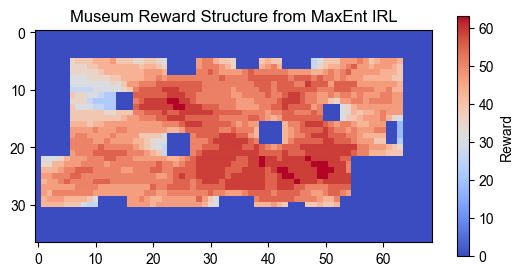

In [44]:
plt.imshow(final_r.T, cmap='coolwarm')
plt.colorbar(label='Reward', shrink=0.65)
plt.title("Museum Reward Structure from MaxEnt IRL")